# 시간대별 쇼핑 클릭 추이수

In [1]:
import naverAPI as napi
import json
from dotenv import load_dotenv

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import koreanize_matplotlib

from matplotlib.dates import DayLocator

In [2]:
current_dir = os.getcwd()
#print(current_dir)
dotenv_path = os.path.join(current_dir, '.env')
load_dotenv(dotenv_path=dotenv_path)
client_id = os.getenv("NAVER_CLIENT_ID")
client_secret = os.getenv("NAVER_CLIENT_SECRET")

categroy_json = pd.read_json('output/naverCategoryTable.json')
df_category = pd.DataFrame(categroy_json)
df_category[df_category['level']==1]


,id,p_id,name,level
0,50000000,0,패션의류,1
78,50000001,0,패션잡화,1
413,50000002,0,화장품/미용,1
595,50000003,0,디지털/가전,1
1421,50000004,0,가구/인테리어,1
1833,50000005,0,출산/육아,1
2359,50000006,0,식품,1
3046,50000007,0,스포츠/레저,1
3618,50000008,0,생활/건강,1
5054,50000009,0,여가/생활편의,1


In [8]:
def draw_shopping_plot(search_cat, startdate, enddate, title, threshold=30, output = 'output/res_temp.json', gender:str="", ages:list=[], device=""):
 # 음식 카테고리
    if isinstance(search_cat, pd.DataFrame):
        search_cat['param'] = search_cat['id'].astype(str).apply(lambda x: [x])
        test_category_list = search_cat[['name', 'param']].to_dict('records')
        # b = search_cat[['id','name']].to_dict('tight')
        # to_be_found = np.array(b['data'])
        # test_category_list = napi.listToCategoryDict(to_be_found)
        res = napi.createTrendData(client_id, client_secret, test_category_list, startdate, enddate, gender=gender, ages=ages, device=device)

        with open(output, 'w', encoding='utf-8') as f:
                    json.dump(res, f, ensure_ascii=False, indent=4)
    
    elif isinstance(search_cat, str):
        with open(search_cat, 'r', encoding='utf-8') as file:
            res = json.load(file)

    
    results = res['datalist']
    all_data = []
    DEFAULT_GROUP = "전체" 

    # 중첩된 구조를 순회하며 'title'과 'group' 정보를 연결
    for item in results:
        current_title = item['title']
        item_data = item['data']
        if item_data:
            is_group_present = 'group' in item_data[0]
        else:
            continue 
        
        for sub_item in item_data:
            if is_group_present:
                current_group = sub_item['group']
            else:
                current_group = DEFAULT_GROUP

            row = {
                'title': current_title,
                'group': current_group, 
                'period': sub_item['period'],
                'ratio': sub_item['ratio']
            }
            all_data.append(row)

    # DataFrame 생성 및 period를 datetime으로 변환
    df = pd.DataFrame(all_data)
    df['period'] = pd.to_datetime(df['period'])

    print("--- 준비된 DataFrame (Title 블록별 Group 처리) ---")
    print(df)
    print("\n--- 'group' 컬럼의 고유 값 ---")
    print(df['group'].unique())

    plt.figure(figsize=(15, 7))
    ax = plt.gca()
    annotation_data = []

    # 2. 'title'과 'group' 컬럼을 조합하여 고유한 그룹핑 기준 생성
    unique_combinations = df.groupby(['title', 'group']).groups.keys()

    # 3. 각 조합별로 반복하며 선 그래프 그리기
    for title_name, group_name in unique_combinations:
        df_combo = df[(df['title'] == title_name) & (df['group'] == group_name)]
        label_name = f"{title_name} - {group_name}"
        
        # plot 함수 실행
        if df_combo['ratio'].max() > threshold:
            line, =plt.plot(
                df_combo['period'], 
                df_combo['ratio'], 
                marker='o',         
                linestyle='-',      
                label=label_name    # 조합별 라벨
        )
            
            if not df_combo.empty:
                last_point = df_combo.iloc[-1]
                annotation_data.append({
                    'x': last_point['period'],
                    'y': last_point['ratio'],
                    'label': label_name,
                    'color': line.get_color() # 플롯에서 할당된 색상을 가져옵니다.
                })

    # 4. 그래프 꾸미기
    plt.title(title)
    plt.xlabel('Period')
    plt.ylabel('Ratio Value')
    plt.ylim((0, 110))
    plt.legend(title='Combination', bbox_to_anchor=(1.05, 1), loc='upper left') 
    plt.grid(True, linestyle='--')
    plt.xticks(rotation=45) 
    ax.xaxis.set_major_locator(DayLocator(interval=1))

    # 모든 x축 레이블 객체를 리스트로 가져옵니다.
    xticklabels = ax.get_xticklabels()

    # 강조하고 싶은 문자열을 정의합니다.
    highlight_name = ["2024-09-14","2024-09-15","2024-09-16","2024-09-17","2024-09-18","2024-09-18", "2025-10-03", "2025-10-04","2025-10-05","2025-10-06","2025-10-07","2025-10-08","2025-10-09", "2025-10-10", "2025-10-11", "2025-10-12"]
    highlight_color = 'red'

    # 레이블 객체를 순회하며 조건 확인
    for label in xticklabels:
        # label.get_text()로 레이블의 문자열 내용을 가져옵니다.
        if label.get_text() in highlight_name:
            label.set_color(highlight_color)
            label.set_fontweight('bold')
            label.set_fontsize(12) # 크기도 변경 가능

    for ann in annotation_data:
        ax.annotate(
            ann['label'],
            xy=(ann['x'], ann['y']),
            xytext=(5, 0), # 라인 끝에서 오른쪽으로 5포인트 이동
            textcoords='offset points',
            color=ann['color'],
            fontsize=10,
            ha='left',
            va='center'
        )
    plt.tight_layout(rect=[0, 0, 0.9, 1])

    plt.show()

    return df


## 사람들이 가장 많이 누른 품목은?
- 추석 전후로 음식이 많을거 같음 $\Rightarrow$ 생활/건강이 많았다
- 의류와 식품이 10/3일에 교차됨
- 전체 클릭수는 추석 연휴보다 전후로 많았다
- 의류 18일 - 19일에 클릭수 급격 증가 $\Rightarrow$ 날씨영향(갑자기 추워질때) -> 아마 겨울의류를 많이 보지 않았을가

11
--- 준비된 DataFrame (Title 블록별 Group 처리) ---
    title group     period      ratio
0    패션의류    전체 2025-09-01  39.077472
1    패션의류    전체 2025-09-02  41.220115
2    패션의류    전체 2025-09-03  41.004757
3    패션의류    전체 2025-09-04  39.248298
4    패션의류    전체 2025-09-05  37.756541
..    ...   ...        ...        ...
534    도서    전체 2025-10-15  10.832310
535    도서    전체 2025-10-16  10.135000
536    도서    전체 2025-10-17   9.639620
537    도서    전체 2025-10-18   8.394170
538    도서    전체 2025-10-19   9.005180

[539 rows x 4 columns]

--- 'group' 컬럼의 고유 값 ---
['전체']


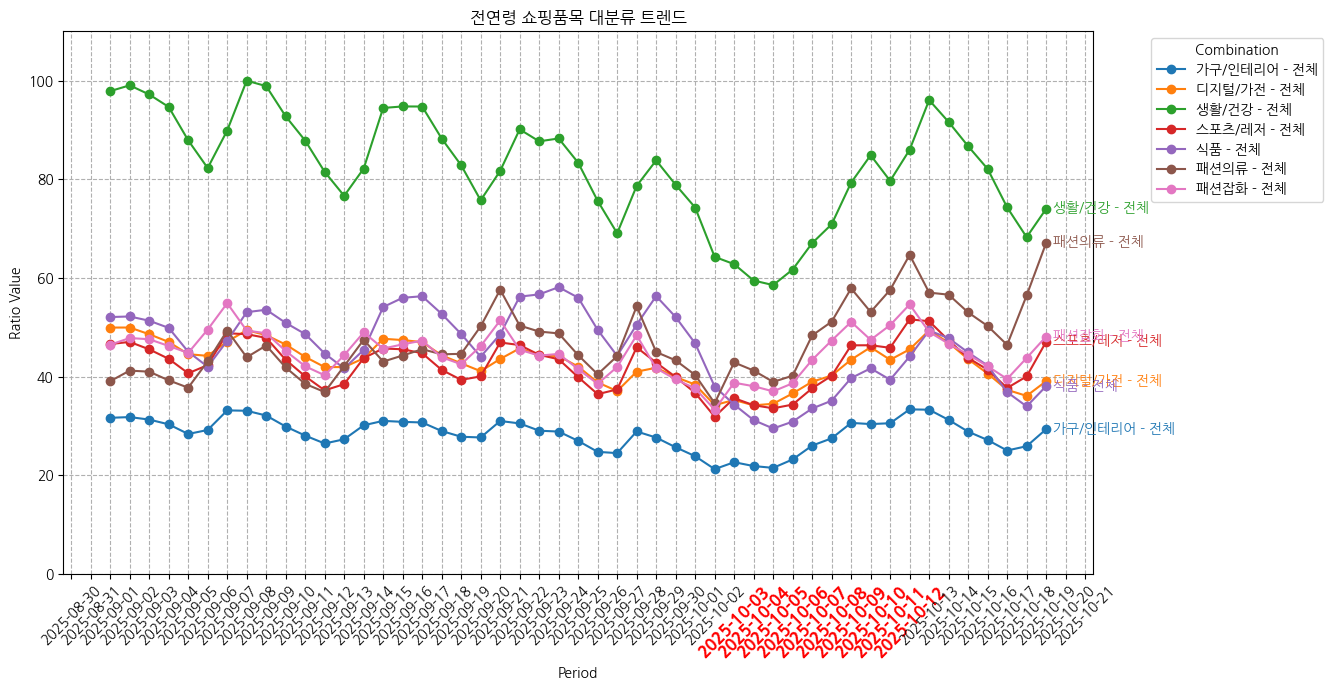

In [ ]:

search_cat = df_category[(df_category['level'] == 1) & (df_category['name'] != '면세점')].copy()

output = 'output/res_allAge.json'
title = '전연령 쇼핑품목 대분류 트렌드'
#res_ageAll1 = draw_shopping_plot(search_cat, "2025-09-26", "2025-10-19", output=output, title = title)
#res_ageAll1 = draw_shopping_plot(output, "2025-09-26", "2025-10-19", title = title)

output = 'output/res_allAge1.json'
title = '전연령 쇼핑품목 대분류 트렌드'
#res_ageAll1 = draw_shopping_plot(search_cat, "2025-09-01", "2025-10-19", output=output, title = title)
#res_ageAll1 = draw_shopping_plot(output, "2025-09-01", "2025-10-19", title = title)

--- 준비된 DataFrame (Title 블록별 Group 처리) ---
    title group     period      ratio
0    패션의류    전체 2025-09-26  43.481200
1    패션의류    전체 2025-09-27  49.332631
2    패션의류    전체 2025-09-28  57.994709
3    패션의류    전체 2025-09-29  45.329019
4    패션의류    전체 2025-09-30  44.359429
..    ...   ...        ...        ...
259    도서    전체 2025-10-15   6.355460
260    도서    전체 2025-10-16   6.255580
261    도서    전체 2025-10-17   6.007710
262    도서    전체 2025-10-18   5.656900
263    도서    전체 2025-10-19   5.719850

[264 rows x 4 columns]

--- 'group' 컬럼의 고유 값 ---
['전체']


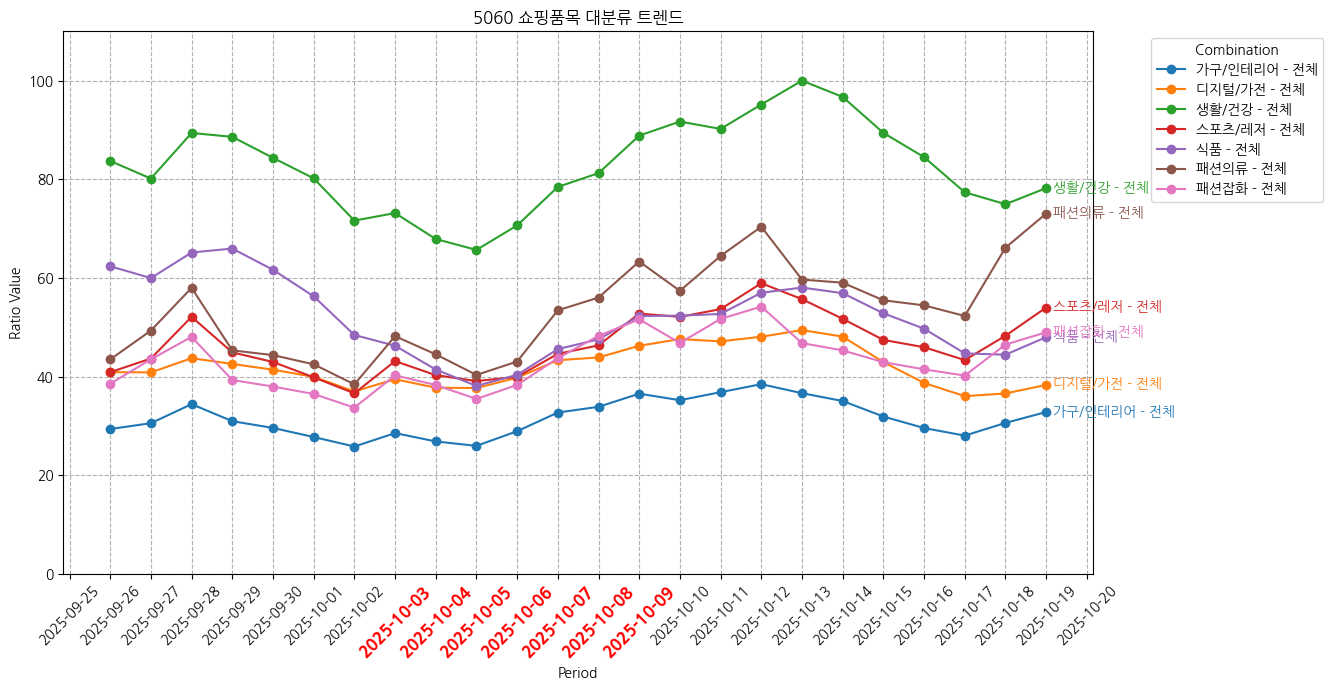

In [36]:
search_cat = df_category[(df_category['level'] == 1) & (df_category['name'] != '면세점')].copy()
#print(search_cat)

output = 'output/res_age2030.json'
#res_age2030 = draw_shopping_plot(search_cat, "2025-09-26", "2025-10-19", '2030 쇼핑품목 대분류 트렌드',output=output, ages=['20', '30'])
#res_age2030 = draw_shopping_plot(output, "2025-09-26", "2025-10-19", '2030 쇼핑품목 대분류 트렌드')

output = 'output/res_age5060.json'
#res_age5060 = draw_shopping_plot(search_cat, "2025-09-26", "2025-10-19", '5060 쇼핑품목 대분류 트렌드',output=output, ages=['50', '60'])
res_age5060 = draw_shopping_plot(output, "2025-09-26", "2025-10-19", '5060 쇼핑품목 대분류 트렌드')


--- 준비된 DataFrame (Title 블록별 Group 처리) ---
    title group     period      ratio
0    패션의류    전체 2025-09-01  20.766731
1    패션의류    전체 2025-09-02  20.952640
2    패션의류    전체 2025-09-03  20.787842
3    패션의류    전체 2025-09-04  19.969196
4    패션의류    전체 2025-09-05  18.812022
..    ...   ...        ...        ...
534    도서    전체 2025-10-15   6.846200
535    도서    전체 2025-10-16   6.474160
536    도서    전체 2025-10-17   6.161360
537    도서    전체 2025-10-18   5.614230
538    도서    전체 2025-10-19   6.108830

[539 rows x 4 columns]

--- 'group' 컬럼의 고유 값 ---
['전체']


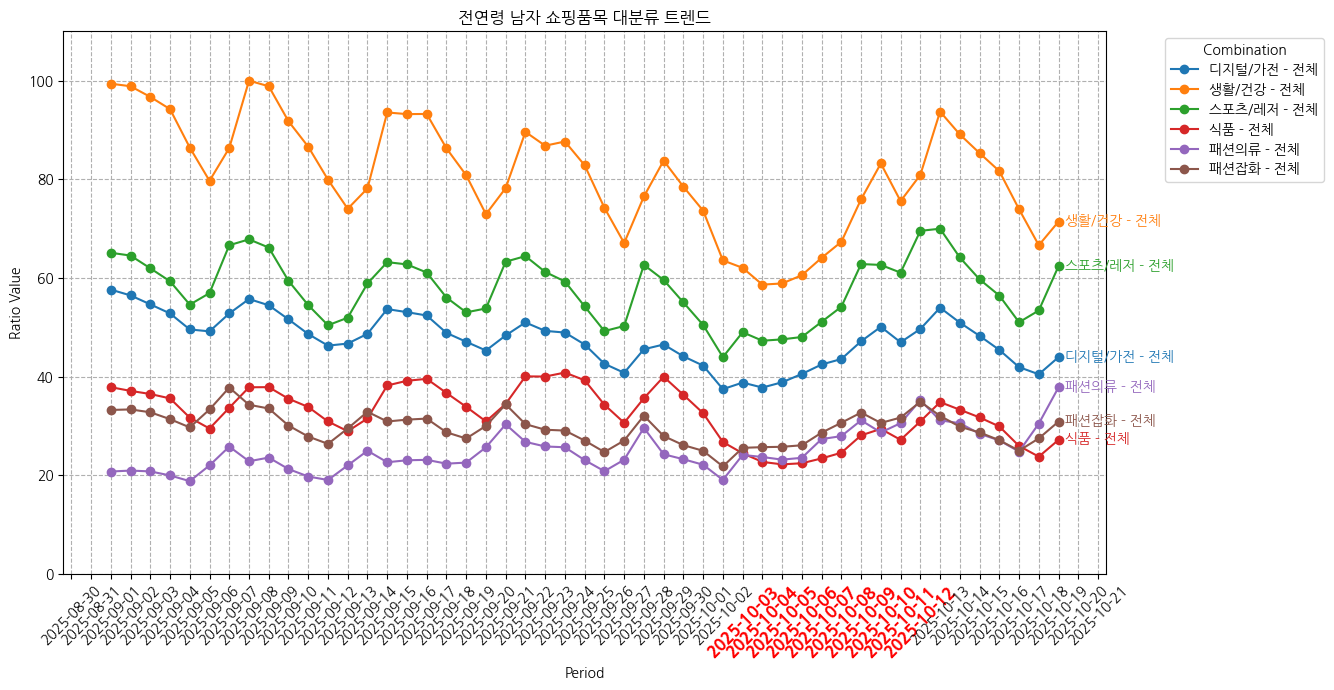

--- 준비된 DataFrame (Title 블록별 Group 처리) ---
    title group     period     ratio
0    패션의류    전체 2025-09-01  59.27536
1    패션의류    전체 2025-09-02  62.71214
2    패션의류    전체 2025-09-03  62.48397
3    패션의류    전체 2025-09-04  59.52555
4    패션의류    전체 2025-09-05  57.57637
..    ...   ...        ...       ...
534    도서    전체 2025-10-15  13.84191
535    도서    전체 2025-10-16  12.95238
536    도서    전체 2025-10-17  12.38659
537    도서    전체 2025-10-18  10.68788
538    도서    전체 2025-10-19  11.36057

[539 rows x 4 columns]

--- 'group' 컬럼의 고유 값 ---
['전체']


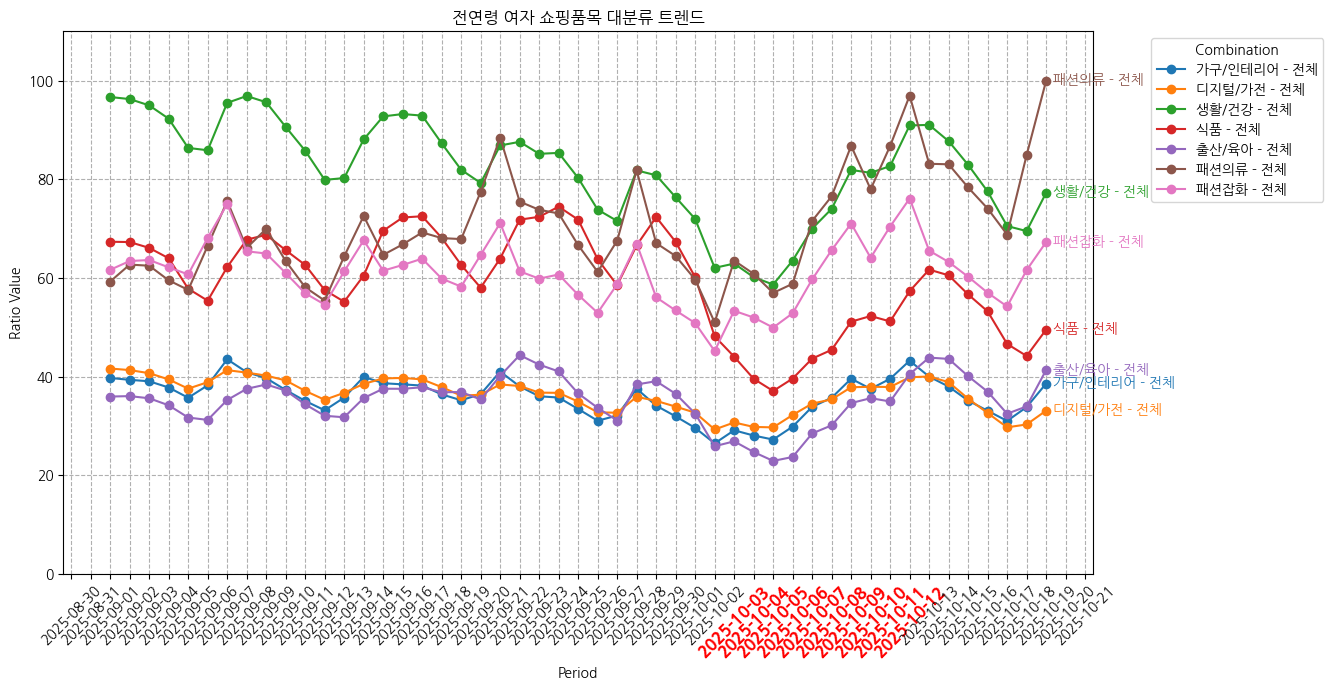

In [43]:
search_cat = df_category[(df_category['level'] == 1) & (df_category['name'] != '면세점')].copy()
#print(search_cat)

# output = 'output/res_allAgeM.json'
# title = '전연령 남자 쇼핑품목 대분류 트렌드'
# res_allAgeM = draw_shopping_plot(search_cat, "2025-09-26", "2025-10-19", title=title,output=output, gender='m')
# #res_allAgeM = draw_shopping_plot(output, "2025-09-26", "2025-10-19", title=title)
output = 'output/res_allAgeM01.json'
title = '전연령 남자 쇼핑품목 대분류 트렌드'
#res_allAgeM = draw_shopping_plot(search_cat, "2025-09-01", "2025-10-19", title=title,output=output, gender='m')
res_allAgeM = draw_shopping_plot(output, "2025-09-01", "2025-10-19", title=title)

# output = 'output/res_allAgeF.json'
# title = '전연령 여자 쇼핑품목 대분류 트렌드'
# res_allAgeF= draw_shopping_plot(search_cat, "2025-09-26", "2025-10-19", title=title ,output=output,gender='f')
# #res_allAgeF = draw_shopping_plot(output, "2025-09-26", "2025-10-19", title=title)
output = 'output/res_allAgeF01.json'
title = '전연령 여자 쇼핑품목 대분류 트렌드'
#res_allAgef = draw_shopping_plot(search_cat, "2025-09-01", "2025-10-19", title=title,output=output, gender='f')
res_allAgef = draw_shopping_plot(output, "2025-09-01", "2025-10-19", title=title, threshold=40)

## 생활/건강이 뭐가 높은거지?
- 추석때 선물로 욕실세트나 아니면 휴지같은것들?, 그러기에는 추석 이후로 더 올라갔는데

**결과**
- 공구가 높다. 이해가 되지 않음 $\Rightarrow$ 공구분류에 많은 카테고리가 있을거 같다. $\Rightarrow$ 생활/건강의 품목이 많아서 그런듯 

34
--- 준비된 DataFrame (Title 블록별 Group 처리) ---
    title group     period      ratio
0      공구    전체 2025-09-26  66.554129
1      공구    전체 2025-09-27  60.754745
2      공구    전체 2025-09-28  66.694064
3      공구    전체 2025-09-29  70.240926
4      공구    전체 2025-09-30  67.565037
..    ...   ...        ...        ...
797   자동차    전체 2025-10-04   0.000230
798   자동차    전체 2025-10-05   0.000230
799   자동차    전체 2025-10-06   0.000230
800   자동차    전체 2025-10-08   0.000710
801   자동차    전체 2025-10-16   0.000230

[802 rows x 4 columns]

--- 'group' 컬럼의 고유 값 ---
['전체']


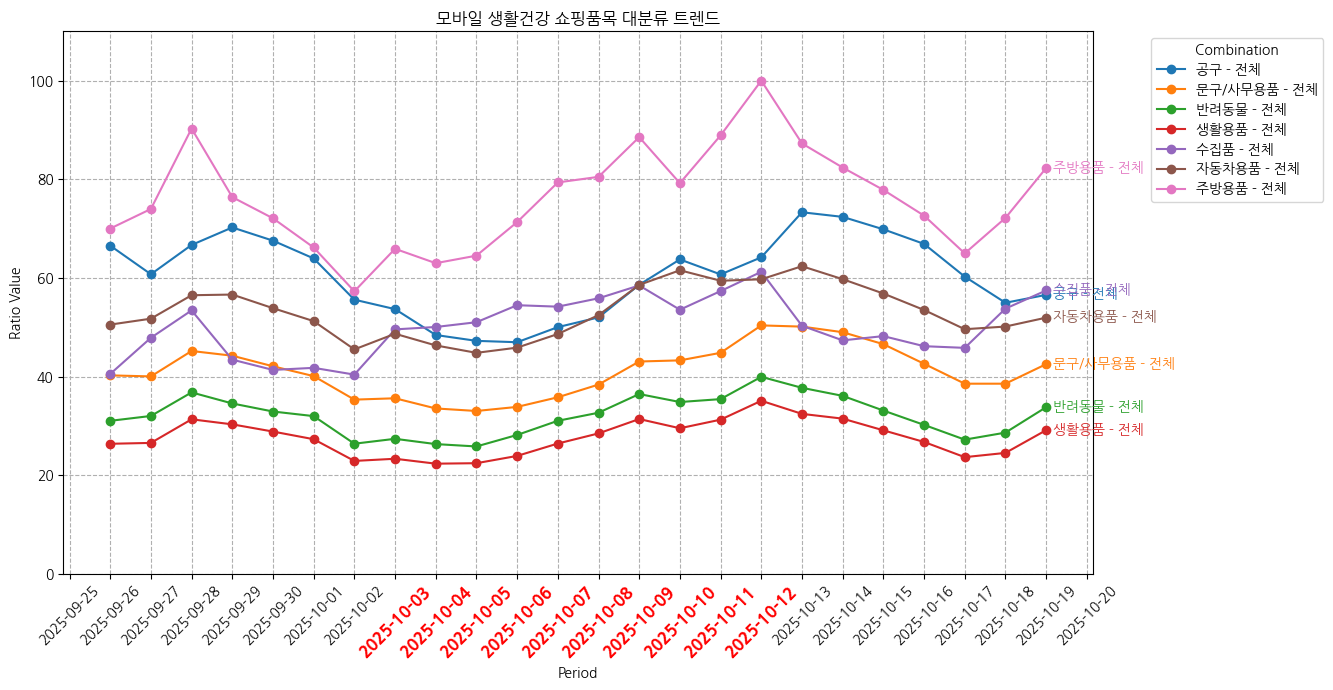

In [ ]:
search_cat = df_category[df_category['p_id'] == 50000008].copy()
output = 'output/res_allAgeM_생활건강.json'
title = '모바일 생활건강 쇼핑품목 중소분류 트렌드'
res_allAge_Life_mo = draw_shopping_plot(search_cat, "2025-09-26", "2025-10-19", title=title,output=output, device='mo')
#res_allAge_Life_mo = draw_shopping_plot(output, "2025-09-26", "2025-10-19", title=title)


In [5]:
cat_list = []
cat_list.append(df_category[df_category['name']=='모형/프라모델/피규어']['id'].values[0])
cat_list.append(df_category[df_category['name']=='전기용품']['id'].values[0])
cat_list.append(df_category[df_category['name']=='전기용품']['id'].values[1])
cat_list.append(df_category[df_category['name']=='식기']['id'].values[0])
cat_list.append(df_category[df_category['name']=='보관/밀폐용기']['id'].values[0])
cat_list.append(df_category[df_category['name']=='주방잡화']['id'].values[0])
cat_list.append(df_category[df_category['name']=='잔/컵']['id'].values[0])
cat_list.append(df_category[df_category['name']=='비데/비데용품']['id'].values[0])
cat_list.append(df_category[df_category['name']=='코스튬플레이']['id'].values[0])

print(cat_list)



[np.int64(50000951), np.int64(50001032), np.int64(50000944), np.int64(50000881), np.int64(50000886), np.int64(50000894), np.int64(50000882), np.int64(50000896), np.int64(50000958)]


[{'name': '전기용품', 'param': ['50001032']}, {'name': '전기용품', 'param': ['50000944']}, {'name': '모형/프라모델/피규어', 'param': ['50000951']}, {'name': '코스튬플레이', 'param': ['50000958']}, {'name': '식기', 'param': ['50000881']}, {'name': '잔/컵', 'param': ['50000882']}, {'name': '보관/밀폐용기', 'param': ['50000886']}, {'name': '주방잡화', 'param': ['50000894']}, {'name': '비데/비데용품', 'param': ['50000896']}]
9
--- 준비된 DataFrame (Title 블록별 Group 처리) ---
       title group     period      ratio
0       전기용품    전체 2025-09-19  30.200817
1       전기용품    전체 2025-09-20  20.809465
2       전기용품    전체 2025-09-21  21.581788
3       전기용품    전체 2025-09-22  34.370122
4       전기용품    전체 2025-09-23  33.524736
..       ...   ...        ...        ...
274  비데/비데용품    전체 2025-10-15   3.773100
275  비데/비데용품    전체 2025-10-16   3.378970
276  비데/비데용품    전체 2025-10-17   2.984320
277  비데/비데용품    전체 2025-10-18   2.900450
278  비데/비데용품    전체 2025-10-19   2.953960

[279 rows x 4 columns]

--- 'group' 컬럼의 고유 값 ---
['전체']


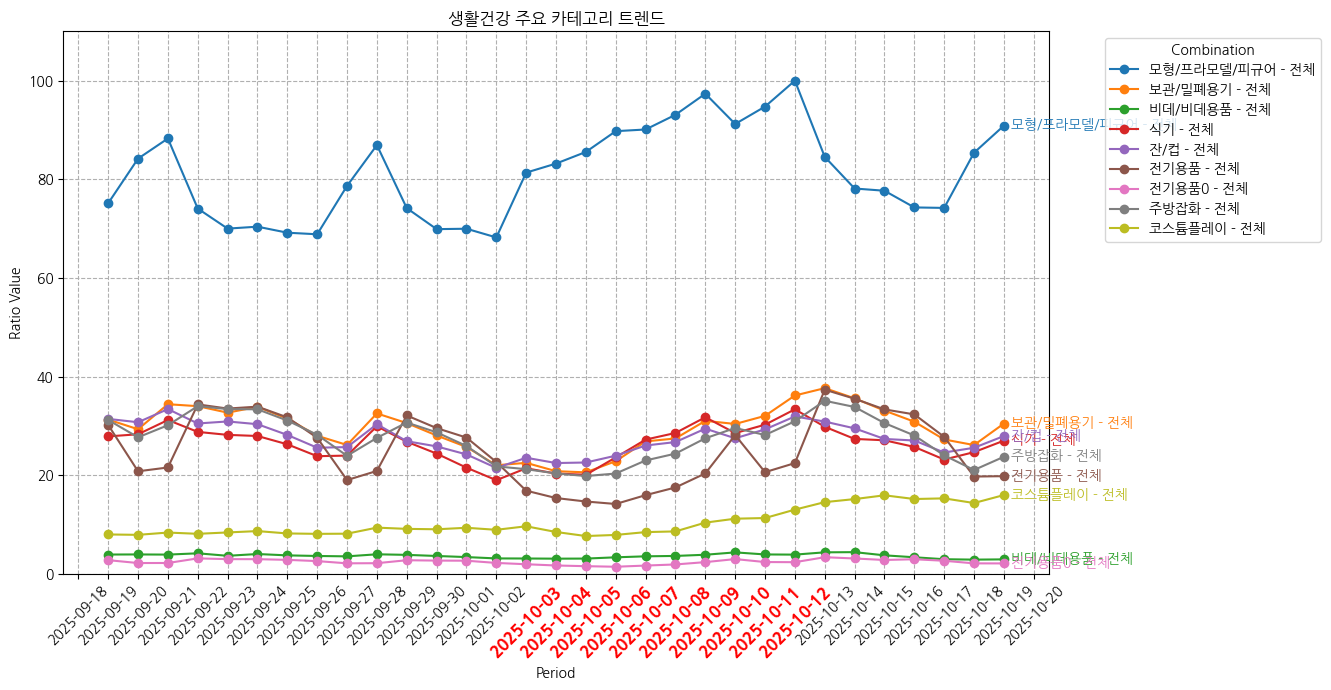

In [ ]:

search_cat = df_category[df_category['id'].isin(cat_list)].copy()
output = 'output/res_allAge_생활건강_주요카테고리.json'
title = '생활건강 주요 카테고리 트렌드'
#res_allAge_Life_mo = draw_shopping_plot(search_cat, "2025-09-19", "2025-10-19", title=title, output=output, threshold = 0)
res_allAge_Life_mo = draw_shopping_plot(output, "2025-09-26", "2025-10-19", title=title)


--- 준비된 DataFrame (Title 블록별 Group 처리) ---
       title group     period      ratio
0       전기용품    전체 2025-09-19  80.183323
1       전기용품    전체 2025-09-20  55.249236
2       전기용품    전체 2025-09-21  57.299758
3       전기용품    전체 2025-09-22  91.252848
4       전기용품    전체 2025-09-23  89.008344
..       ...   ...        ...        ...
243  비데/비데용품    전체 2025-10-15  10.017620
244  비데/비데용품    전체 2025-10-16   8.971180
245  비데/비데용품    전체 2025-10-17   7.923380
246  비데/비데용품    전체 2025-10-18   7.700710
247  비데/비데용품    전체 2025-10-19   7.842780

[248 rows x 4 columns]

--- 'group' 컬럼의 고유 값 ---
['전체']


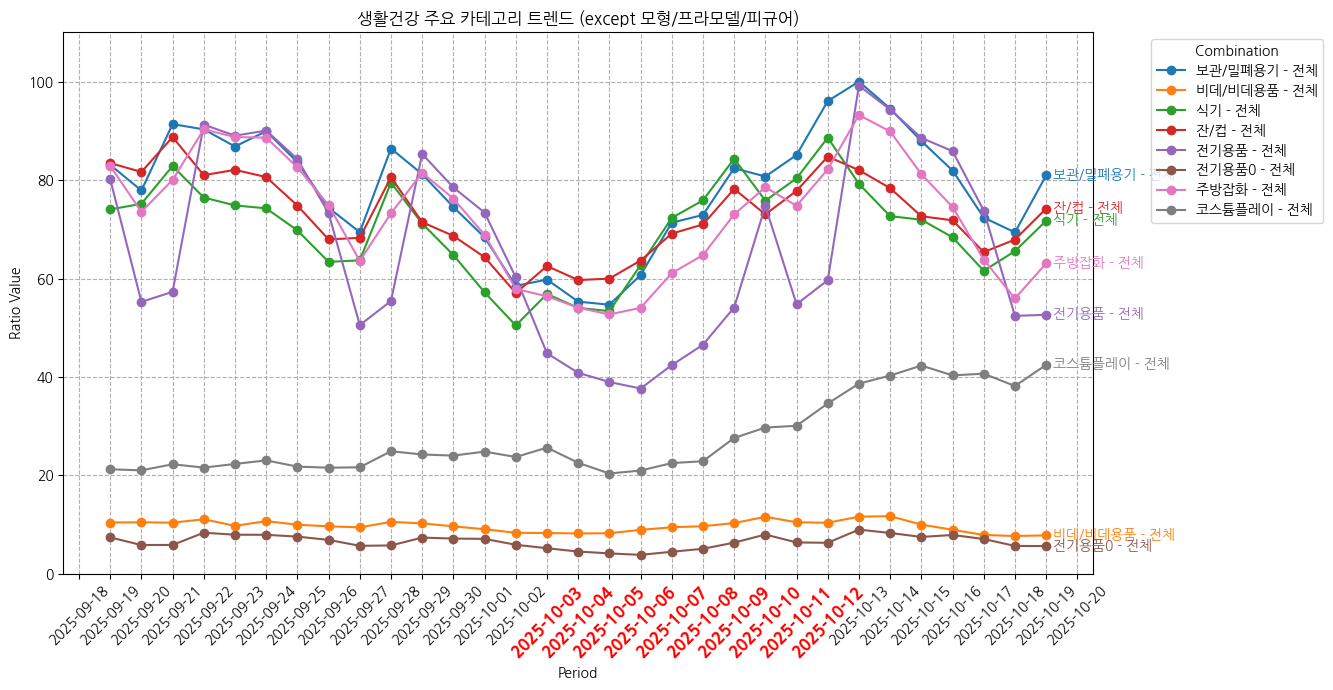

In [9]:
cond = df_category['name'].isin(['전기용품', '식기', '보관/밀폐용기', '주방잡화', '잔/컵', '비데/비데용품', '코스튬플레이'])
search_cat = df_category[cond].copy()
output = 'output/res_allAge_생활건강_주요카테고리_except모델.json'
title = '생활건강 주요 카테고리 트렌드 (except 모형/프라모델/피규어)'
res = draw_shopping_plot(search_cat, "2025-09-19", "2025-10-19", title=title, output=output, threshold = 0)
#res = draw_shopping_plot(output, "2025-09-26", "2025-10-19", title=title)

--- 준비된 DataFrame (Title 블록별 Group 처리) ---
          title group     period     ratio
0   모형/프라모델/피규어    전체 2025-09-19  69.68070
1   모형/프라모델/피규어    전체 2025-09-20  77.76561
2   모형/프라모델/피규어    전체 2025-09-21  85.99471
3   모형/프라모델/피규어    전체 2025-09-22  74.09665
4   모형/프라모델/피규어    전체 2025-09-23  69.14043
..          ...   ...        ...       ...
57       코스튬플레이    전체 2025-10-15   5.93773
58       코스튬플레이    전체 2025-10-16   5.82308
59       코스튬플레이    전체 2025-10-17   5.87867
60       코스튬플레이    전체 2025-10-18   4.91974
61       코스튬플레이    전체 2025-10-19   6.24001

[62 rows x 4 columns]

--- 'group' 컬럼의 고유 값 ---
['전체']


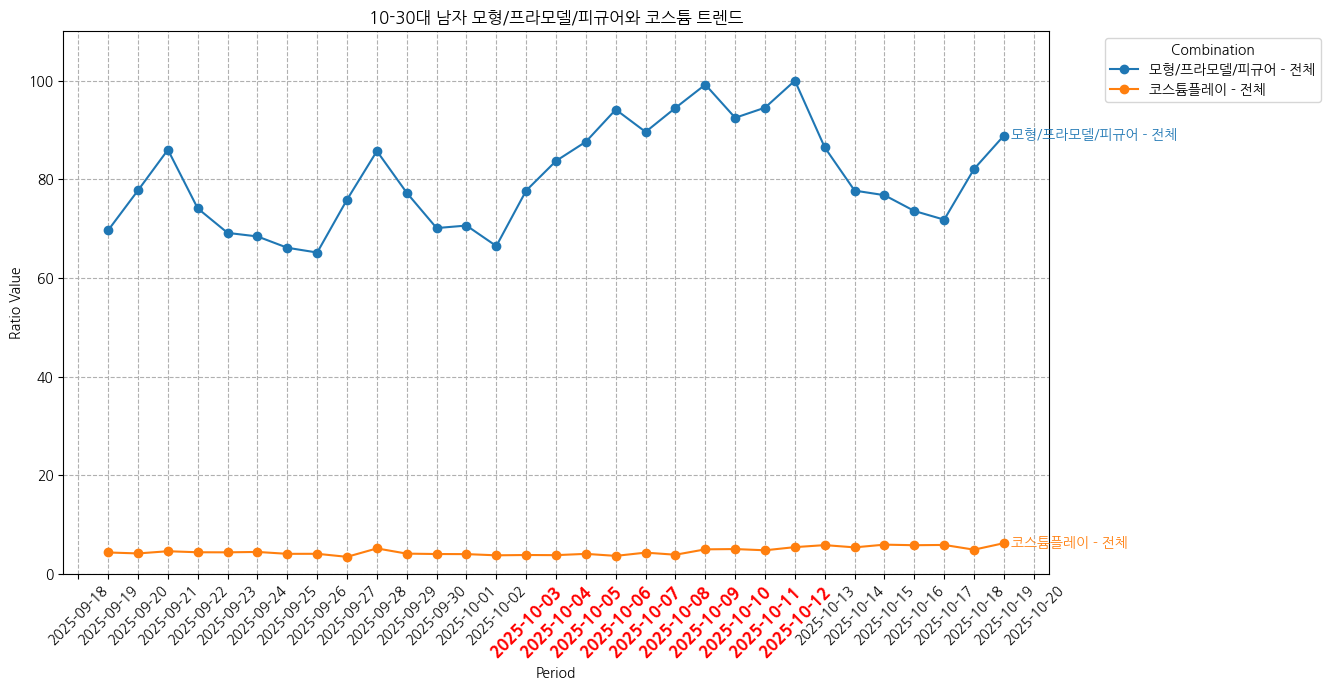

In [20]:
cond = df_category['name'].isin(['모형/프라모델/피규어', '코스튬플레이'])
search_cat = df_category[cond].copy()
output = 'output/res_all102030남_생활건강_피코.json'
title = '10-30대 남자 모형/프라모델/피규어와 코스튬 트렌드'
res = draw_shopping_plot(search_cat, "2025-09-19", "2025-10-19", title=title, output=output, threshold = 0, gender='m', ages=['10', '20', '30'])
#res = draw_shopping_plot(output, "2025-09-19", "2025-10-19", title=title, threshold=0)

--- 준비된 DataFrame (Title 블록별 Group 처리) ---
          title group     period     ratio
0   모형/프라모델/피규어    전체 2025-09-19  78.83004
1   모형/프라모델/피규어    전체 2025-09-20  85.43885
2   모형/프라모델/피규어    전체 2025-09-21  87.76242
3   모형/프라모델/피규어    전체 2025-09-22  75.82910
4   모형/프라모델/피규어    전체 2025-09-23  69.61263
..          ...   ...        ...       ...
57       코스튬플레이    전체 2025-10-15  17.30107
58       코스튬플레이    전체 2025-10-16  16.47797
59       코스튬플레이    전체 2025-10-17  16.45715
60       코스튬플레이    전체 2025-10-18  14.69085
61       코스튬플레이    전체 2025-10-19  16.50839

[62 rows x 4 columns]

--- 'group' 컬럼의 고유 값 ---
['전체']


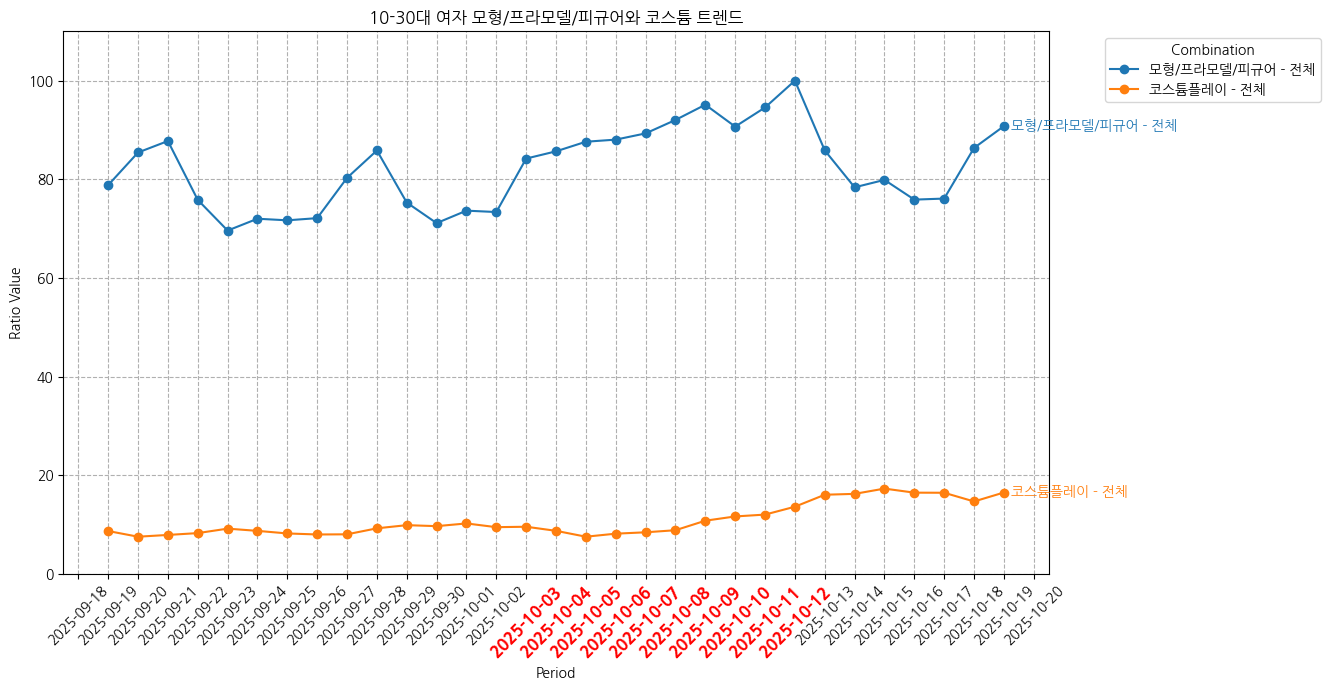

In [21]:
cond = df_category['name'].isin(['모형/프라모델/피규어', '코스튬플레이'])
search_cat = df_category[cond].copy()
output = 'output/res_all102030여_생활건강_피코카테고리.json'
title = '10-30대 여자 모형/프라모델/피규어와 코스튬 트렌드'
res = draw_shopping_plot(search_cat, "2025-09-19", "2025-10-19", title=title, output=output, threshold = 0, gender='f', ages=['10', '20', '30'])
#res = draw_shopping_plot(output, "2025-09-19", "2025-10-19", title=title, threshold=0)

--- 준비된 DataFrame (Title 블록별 Group 처리) ---
          title group     period     ratio
0   모형/프라모델/피규어    전체 2025-09-19  72.55198
1   모형/프라모델/피규어    전체 2025-09-20  80.52225
2   모형/프라모델/피규어    전체 2025-09-21  86.55044
3   모형/프라모델/피규어    전체 2025-09-22  74.19008
4   모형/프라모델/피규어    전체 2025-09-23  70.13942
..          ...   ...        ...       ...
57       코스튬플레이    전체 2025-10-15   7.26454
58       코스튬플레이    전체 2025-10-16   6.79943
59       코스튬플레이    전체 2025-10-17   7.00889
60       코스튬플레이    전체 2025-10-18   6.65119
61       코스튬플레이    전체 2025-10-19   8.37844

[62 rows x 4 columns]

--- 'group' 컬럼의 고유 값 ---
['전체']


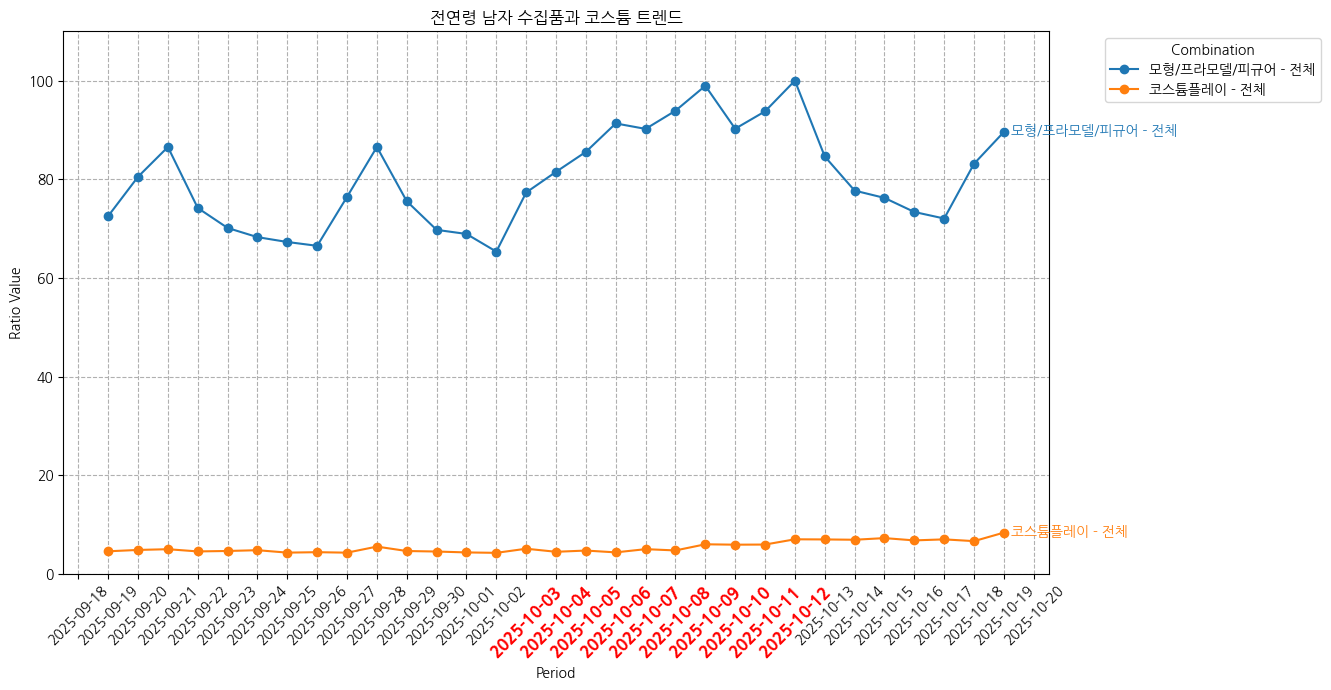

--- 준비된 DataFrame (Title 블록별 Group 처리) ---
          title group     period     ratio
0   모형/프라모델/피규어    전체 2025-09-19  78.71694
1   모형/프라모델/피규어    전체 2025-09-20  88.25202
2   모형/프라모델/피규어    전체 2025-09-21  89.77548
3   모형/프라모델/피규어    전체 2025-09-22  75.10843
4   모형/프라모델/피규어    전체 2025-09-23  70.15449
..          ...   ...        ...       ...
57       코스튬플레이    전체 2025-10-15  25.66106
58       코스튬플레이    전체 2025-10-16  24.41003
59       코스튬플레이    전체 2025-10-17  24.37896
60       코스튬플레이    전체 2025-10-18  23.07058
61       코스튬플레이    전체 2025-10-19  24.56058

[62 rows x 4 columns]

--- 'group' 컬럼의 고유 값 ---
['전체']


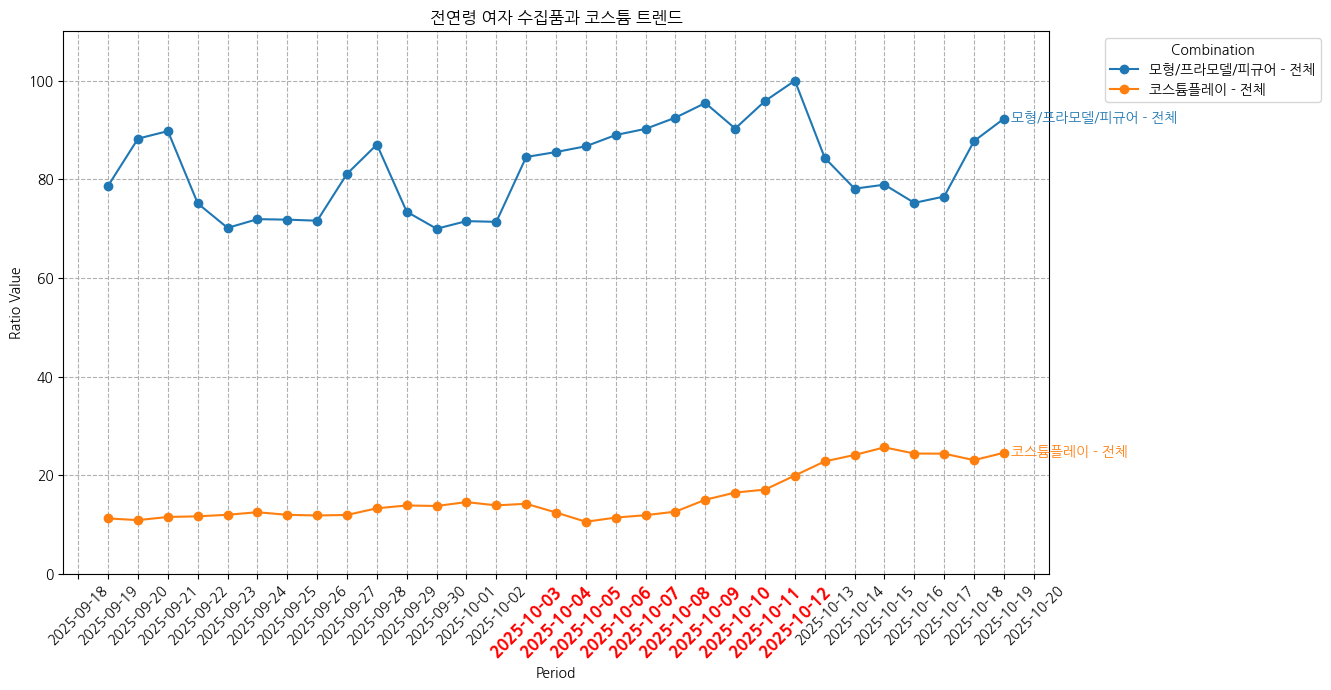

In [22]:
cond = df_category['name'].isin(['모형/프라모델/피규어', '코스튬플레이'])

search_cat = df_category[cond].copy()
output = 'output/res_all남_생활건강_피코카테고리.json'
title = '전연령 남자 수집품과 코스튬 트렌드'
res = draw_shopping_plot(search_cat, "2025-09-19", "2025-10-19", title=title, output=output, threshold = 0, gender='m')
#res = draw_shopping_plot(output, "2025-09-19", "2025-10-19", title=title, threshold=0)

search_cat = df_category[cond].copy()
output = 'output/res_all여_생활건강_피코카테고리.json'
title = '전연령 여자 수집품과 코스튬 트렌드'
res = draw_shopping_plot(search_cat, "2025-09-19", "2025-10-19", title=title, output=output, threshold = 0, gender='f')
#res = draw_shopping_plot(output, "2025-09-26", "2025-10-19", title=title, threshold=0)

## 다음은 음식에 대해서 보자

## 다음은 의류에 대해서 보자
**결과**
- 아까 봤듯이 날씨 때문에 10/18, 10/19에 클릭수 급증
- 남성의류와 여성의류 검색 추이 비슷
    - 궁금한점 : 남자, 여자는 무슨 의류를 더많이 검색했을까



In [32]:

print(df_category[df_category['name']=='패션의류'] )
search_cat = df_category[(df_category['p_id'] == 50000000)]
print(len(search_cat))
print(search_cat['name'])
draw_shopping_plot(search_cat, "2025-09-20", "2025-10-19", threshold=0, gender="f")

         id  p_id  name  level
0  50000000     0  패션의류      1
4
1          여성의류
23    여성언더웨어/잠옷
48         남성의류
66    남성언더웨어/잠옷
Name: name, dtype: object
4


HTTPError: HTTP Error 429: Too Many Requests

         id  p_id  name  level
0  50000000     0  패션의류      1
4
1          여성의류
23    여성언더웨어/잠옷
48         남성의류
66    남성언더웨어/잠옷
Name: name, dtype: object
4


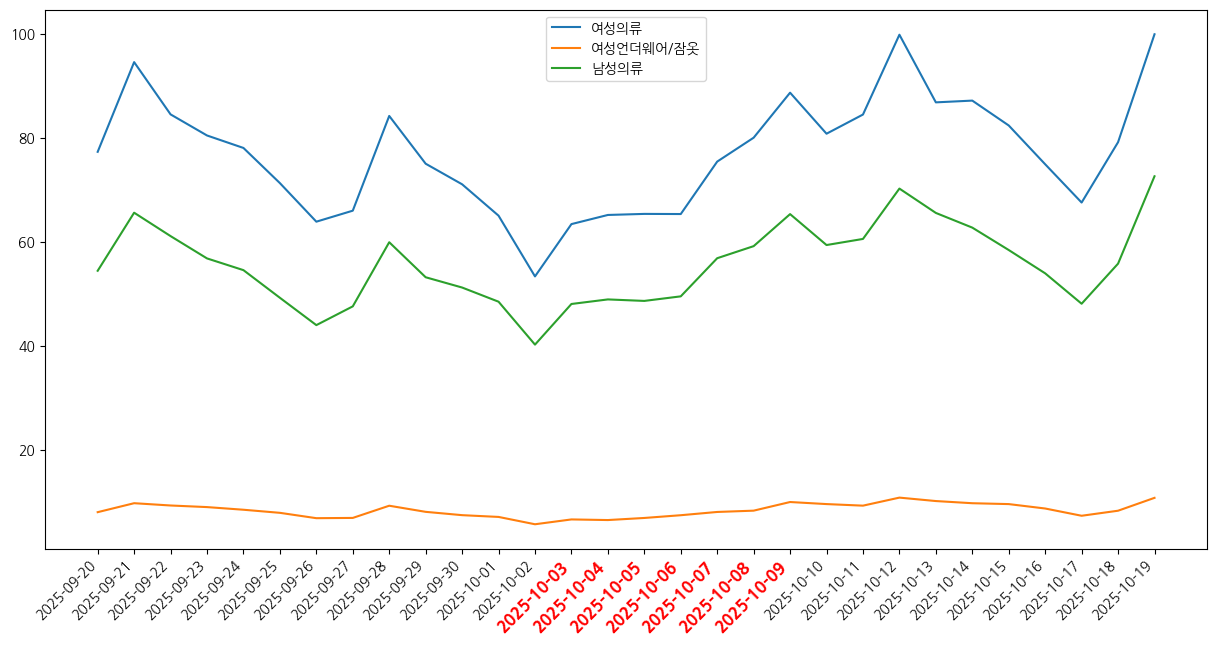

In [16]:

print(df_category[df_category['name']=='패션의류'] )
search_cat = df_category[(df_category['p_id'] == 50000000)]
print(len(search_cat))
print(search_cat['name'])

draw_shopping_plot(search_cat, "2025-09-20", "2025-10-19", threshold=10, ages=['10', '20', '30'])